In [1]:
import cartopy.crs
from cartopy import feature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean.cm
import numpy
import xarray
import pandas
import pathlib
import yaml

In [2]:
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)

fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")

location_dir = pathlib.Path('/Users/rmueller/Data/MIDOSS/AIS')
location_file = location_dir / 'Oil_Transfer_Facilities.xlsx'
wa_oil_in = pathlib.Path('/Users/rmueller/Data/MIDOSS/marine_transport_data') / 'WA_destination.yaml'
wa_oil_out = pathlib.Path('/Users/rmueller/Data/MIDOSS/marine_transport_data') / 'WA_origin.yaml'


In [3]:
vessel_types = [
    'tanker', 
    'atb', 
    'barge'
]
oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]
oil_colors = [
    'darkolivegreen',
    'olivedrab',
    'slategrey',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]
gallons_to_liters = 3.78541

In [12]:
# import yaml
# yaml_file = '/Users/rmueller/Data/MIDOSS/marine_transport_data/Pacific_origin.yaml'
# with open(yaml_file,"r") as file:
#         cargo = yaml.safe_load(file)
spill_locations = '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/data/SalishSea_oil_spills_10000.csv'
spill_locs = pandas.read_csv(spill_locations)

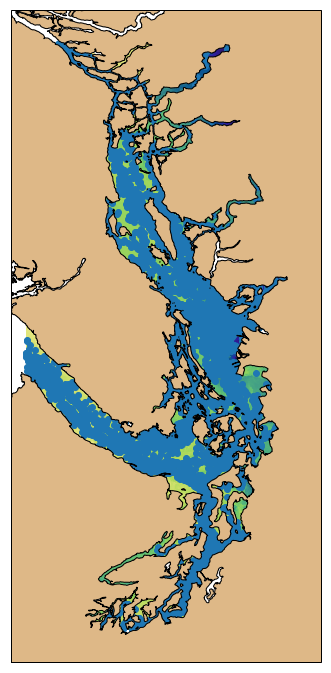

In [14]:
# the offsets needed for indexing from lower left of graphic boundary
x0 = -0.12
y0 = -0.044

salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

fig,ax = plt.subplots(
    1, 1, figsize=(12, 12), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)
ax.scatter(spill_locs.spill_lon, spill_locs.spill_lat, transform=plain_crs)


#ax_north.bar(oil_types, 1e1* numpy.ones(7), width = 1)
plt.show()
fig.canvas.draw()
fig.tight_layout()
    

### Remove locations with no spill information and sort by oil type

In [17]:
spill_locs[:0]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_mmsi,spill_volume,spill_type


In [44]:
spill_locs_clean = spill_locs[spill_locs.spill_volume != -99999]
spill_locs_byoil = {}
for oil in oil_types:
    spill_locs_byoil["{0}".format(oil)] = spill_locs_clean[
        spill_locs_clean.spill_type==oil
    ]
    len_array = len(spill_locs_byoil[oil])
    print(f'{oil}: {len_array}')

akns: 0
bunker: 3249
dilbit: 0
jet: 0
diesel: 6674
gas: 0
other: 0


In [51]:
# For comparison: 
# Max spill volume of tanker cargo is 185447000 liters
# Min spill volume of barge cargo is 1500000 liters
max_spill_volume = max(spill_locs_clean.spill_volume)
min_spill_volume = min(spill_locs_clean.spill_volume)
median_spill_volume = numpy.median(spill_locs_clean.spill_volume)
print(f'Min: {min_spill_volume}, Max: {max_spill_volume}, Median: {median_spill_volume}')

Min: 1.0, Max: 157629950.0, Median: 63293.361318515344


In [61]:
# Weight spill volumes by max volume for plotting 
spill_volume_fraction = {}
spill_volume_fraction['bunker'] = spill_locs_byoil['bunker'].spill_volume/max_spill_volume 
spill_volume_fraction['diesel'] = spill_locs_byoil['diesel'].spill_volume/max_spill_volume 

In [ ]:
oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]
oil_colors = [
    'darkolivegreen',
    'olivedrab',
    'slategrey',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]

0
1


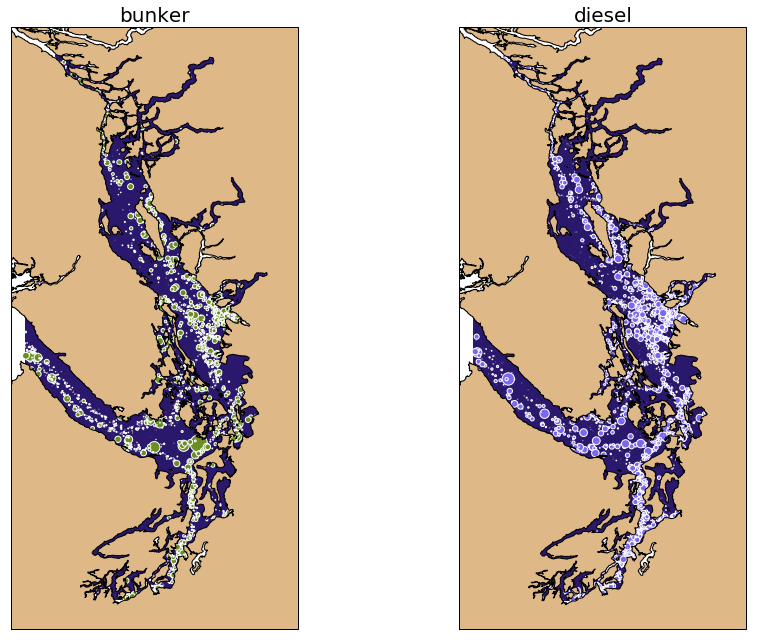

In [69]:
fs = 20
ms = 300

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

fig,axs = plt.subplots(
    1, 2, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

terminal_loc = 0

index = 0
for ax in axs:
    print(index)
  
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
    quad_mesh = ax.pcolormesh(
        georef.longitude, georef.latitude, 0*salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
    )
    if ax == axs[0]:
        ax.scatter(spill_locs_byoil['bunker'].spill_lon, 
                   spill_locs_byoil['bunker'].spill_lat, 
                   s = ms * spill_volume_fraction['bunker'],
                   color=oil_colors[1],
                   edgecolors='white',
                   linewidth=1,
                   transform=plain_crs)
        ax.set_title('bunker', fontsize=fs)
    else:
         ax.scatter(spill_locs_byoil['diesel'].spill_lon, 
                   spill_locs_byoil['diesel'].spill_lat, 
                   s = ms * spill_volume_fraction['diesel'],
                   color=oil_colors[4],
                   edgecolors='white',
                   linewidth=1,
                   transform=plain_crs)
         ax.set_title('diesel', fontsize=fs)
    
#     # calculate location of marine terminal within graphic window
#     xleft = ((wa_locs.DockLongNumber[index] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
#     ybottom   = ((wa_locs.DockLatNumber[index] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()
   
#     ax_sub= inset_axes(ax, width=0.5, height=0.5, 
#                    bbox_to_anchor=(xleft, ybottom),
#                    bbox_transform=ax.transAxes,
#                    axes_class=cartopy.mpl.geoaxes.GeoAxes, 
#                    axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()), 
#                    borderpad=0)
    
    fig.canvas.draw()
    fig.tight_layout()
    
    index += 1

plt.show()